# Intra-annual variability of precipitation - code
> A comparison between the seasonality of Tel Aviv and London

- toc: true 
- badges: true
- comments: false
- categories: [jupyter]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from calendar import month_abbr
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
import urllib.request

# import data

Go to NOAA's National Centers for Environmental Information (NCEI)  
[Climate Data Online: Dataset Discovery](https://www.ncdc.noaa.gov/cdo-web/datasets)

Find station codes in this [map](https://gis.ncdc.noaa.gov/maps/ncei/cdo/monthly)

In [3]:
def download_data(station_name, station_code):
    url_daily = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    url_monthly = 'https://www.ncei.noaa.gov/data/gsom/access/'
    # download daily data
    urllib.request.urlretrieve(url_daily + station_code + '.csv',
                               station_name + '_daily.csv')
    # download monthly data
    urllib.request.urlretrieve(url_monthly + station_code + '.csv',
                               station_name + '_monthly.csv')

# calculate monthly averages

In [4]:
month_numbers = np.arange(1,13)
month_names = [month_abbr[i] for i in month_numbers]

def monthly_mean(station_name, freq):
    # import daily data
    
    df = pd.read_csv(station_name + '_' + freq + '.csv', sep=",")
    # make 'DATE' the dataframe index
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.set_index('DATE')
    print(df.index[0], df.index[-1])
    if freq == 'daily':
        # resample data by month
        df_month = df['PRCP'].resample('M').sum()  # sum is labeled at the last day of the month 
        df_month = df_month/10                     # PRCP is given in tens of mm (see readme)
    if freq == 'monthly':
        df_month = df['PRCP']
    # calculate monthly mean
    monthly_mean = np.array([])  # empty array
    for m in month_numbers:      # cycle over months (1, 2, 3, etc)
        this_month_all_indices = (df_month.index.month == m)       # indices in df_month belonging to month m
        this_month_mean = df_month[this_month_all_indices].mean()  # this is the monthly mean
        monthly_mean = np.append(monthly_mean, this_month_mean)    # append
    # make new df and return it
    df_return = pd.DataFrame({'monthly rainfall (mm)':monthly_mean,
                              'month names':month_names,
                              'month number':month_numbers
                            })
    return df_return

In [5]:
# download_data('LONDON HEATHROW', 'UKM00003772')
# download_data('TEL AVIV READING', 'IS000002011')
# download_data('SAO PAULO', 'BR00E3-0520')

In [6]:
# load monthly mean
df_london = monthly_mean("LONDON HEATHROW", 'monthly')
df_telaviv = monthly_mean("TEL AVIV READING", 'monthly')
df_saopaulo = monthly_mean("SAO PAULO", 'monthly')
total_london = df_london['monthly rainfall (mm)'].sum()
total_telaviv = df_telaviv['monthly rainfall (mm)'].sum()

1973-01-01 00:00:00 2021-02-01 00:00:00
1939-11-01 00:00:00 1999-11-01 00:00:00
1940-04-01 00:00:00 2021-02-01 00:00:00


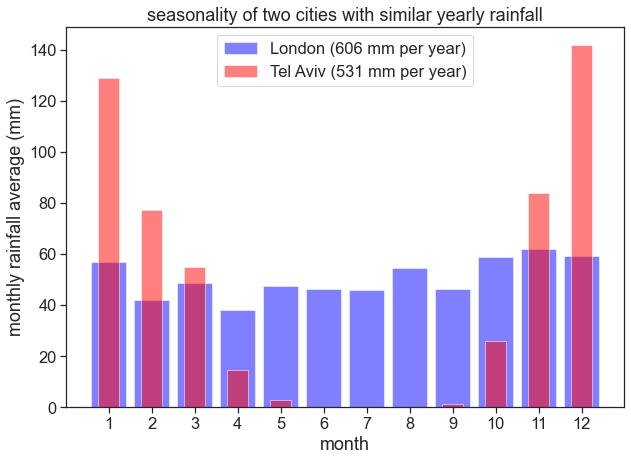

In [7]:
fig, ax = plt.subplots(figsize=(10,7))

# bar plots
ax.bar(df_london['month number'], df_london['monthly rainfall (mm)'],
        alpha=0.5, color="blue", label=f"London ({total_london:.0f} mm per year)")
ax.bar(df_telaviv['month number'], df_telaviv['monthly rainfall (mm)'],
        alpha=0.5, color="red", width=0.5, label=f"Tel Aviv ({total_telaviv:.0f} mm per year)")

# axes labels and figure title
ax.set_xlabel('month')
ax.set_ylabel('monthly rainfall average (mm)')
ax.set_title('seasonality of two cities with similar yearly rainfall')

# some ticks adjustments
ax.set_xticks(month_numbers)
plt.legend(loc='upper center')

# save figure
plt.savefig("hydrology_figures/monthly_tel_aviv_london_bars.png")

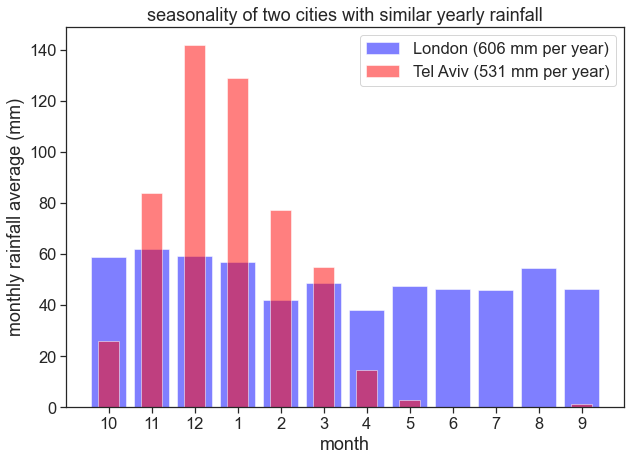

In [8]:
fig, ax = plt.subplots(figsize=(10,7))

# hydrological year starts in October, roll data by 9 months
months = df_london['month number']
months_to_roll = -9  # minus sign = roll data to the left
london_rolled = np.roll(df_london['monthly rainfall (mm)'], months_to_roll)
telaviv_rolled = np.roll(df_telaviv['monthly rainfall (mm)'], months_to_roll)
months_rolled = np.roll(months, months_to_roll)
months_rolled_str = [str(x) for x in months_rolled]

# bar plots
ax.bar(months, london_rolled,
       alpha=0.5, color="blue",
       label=f"London ({total_london:.0f} mm per year)")
ax.bar(months, telaviv_rolled,
       alpha=0.5, color="red", width=0.5,
       label=f"Tel Aviv ({total_telaviv:.0f} mm per year)")

# axes labels and figure title
ax.set_xlabel('month')
ax.set_ylabel('monthly rainfall average (mm)')
ax.set_title('seasonality of two cities with similar yearly rainfall')

# some ticks adjustments
#
ax.set_xticks(months)
ax.set_xticklabels(months_rolled_str)
plt.legend(loc='upper right')

# save figure
plt.savefig("hydrology_figures/monthly_tel_aviv_london_bars_hydrological_year.png")

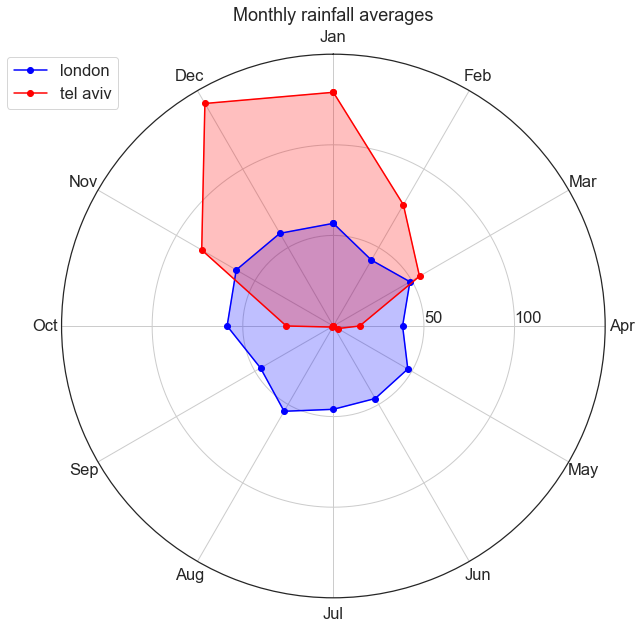

In [9]:
fig = plt.figure(figsize=(10,10))

# radar chart
ax = fig.add_subplot(111, polar=True)     # make polar plot
ax.set_theta_zero_location("N")           # January on top ("N"orth)
ax.set_theta_direction(-1)                # clockwise direction
ax.set_rlabel_position(90)                # radial labels on the right
ax.set_rticks([50,100])                   # two radial ticks is enough
ax.set_rlim(0,150)                        # limits of r axis
angles=np.linspace(0, 2*np.pi, 12, endpoint=False)       # divide circle into 12 slices
angles=np.append(angles, angles[0])                      # close loop, otherwise lines will be open
ax.set_thetagrids(angles[:-1] * 180/np.pi, month_names)  # relabel angles with month names

# plot london data
stats_london = np.array(df_london['monthly rainfall (mm)'])        # get london data
stats_london = np.append(stats_london, stats_london[0])            # close loop
ax.plot(angles, stats_london, "o-", color='blue', label="london")  # plot line
ax.fill(angles, stats_london, alpha=0.25, color='blue')            # fill

# plot tel aviv data
stats_telaviv = np.array(df_telaviv['monthly rainfall (mm)'])        # get tel aviv data
stats_telaviv = np.append(stats_telaviv, stats_telaviv[0])           # close loop
ax.plot(angles, stats_telaviv, "o-", color='red', label="tel aviv")  # plot line
ax.fill(angles, stats_telaviv, alpha=0.25, color='red')              # fill

# plot sao paulo data
# stats_saopaulo = np.array(df_saopaulo['monthly rainfall (mm)'])        # get tel aviv data
# stats_saopaulo = np.append(stats_saopaulo, stats_saopaulo[0])           # close loop
# ax.plot(angles, stats_saopaulo, "o-", color='green', label="sao paulo")  # plot line
# ax.fill(angles, stats_saopaulo, alpha=0.25, color='green')              # fill

ax.set_title("Monthly rainfall averages")
ax.legend(loc=(-0.1,0.9))  # legend at x=-0.2 so it doesn't overlap with graph

# save figure
plt.savefig("hydrology_figures/radar_chart_tel_aviv_london.png")

In [6]:
station_name = "LONDON HEATHROW"

freq = 'daily'
df_day = pd.read_csv(station_name + '_' + freq + '.csv', sep=",")
# make 'DATE' the dataframe index
df_day['DATE'] = pd.to_datetime(df_day['DATE'])
df_day = df_day.set_index('DATE')
# resample data by month
df_month1 = df_day['PRCP'].resample('MS').sum()  # sum is labeled at the last day of the month 
df_month1 = df_month1/10                     # PRCP is given in tens of mm (see readme)

freq = 'monthly'
df_mon = pd.read_csv(station_name + '_' + freq + '.csv', sep=",")
# make 'DATE' the dataframe index
df_mon['DATE'] = pd.to_datetime(df_mon['DATE'])
df_mon = df_mon.set_index('DATE')
# resample data by month
df_month2 = df_mon['PRCP']

<IPython.core.display.Javascript object>


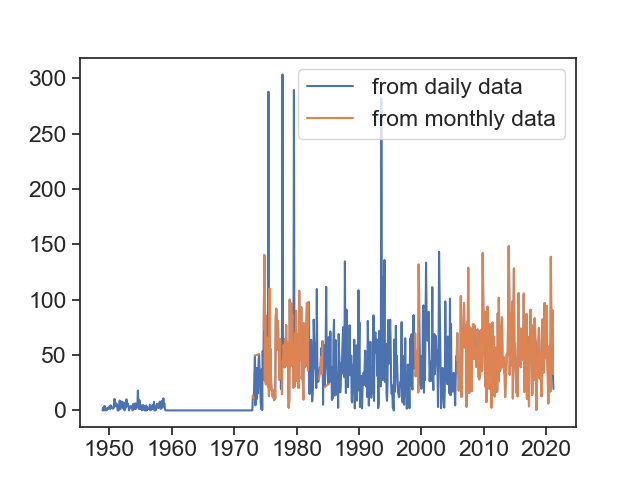

In [7]:
%matplotlib notebook
plt.plot(df_month1, label='from daily data')
plt.plot(df_month2, label='from monthly data')
plt.legend()

<IPython.core.display.Javascript object>


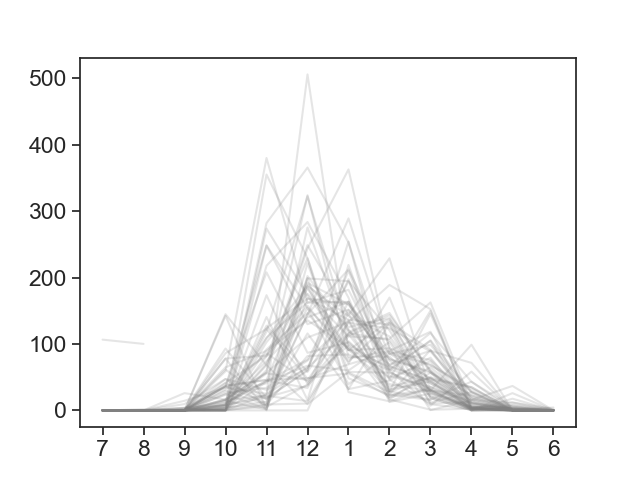

([<matplotlib.axis.XTick at 0x7f83097830d0>,
 [Text(1, 0, '7'),
  Text(2, 0, '8'),
  Text(3, 0, '9'),
  Text(4, 0, '10'),
  Text(5, 0, '11'),
  Text(6, 0, '12'),
  Text(7, 0, '1'),
  Text(8, 0, '2'),
  Text(9, 0, '3'),
  Text(10, 0, '4'),
  Text(11, 0, '5'),
  Text(12, 0, '6')])

In [34]:
%matplotlib notebook
df = pd.read_csv("TEL AVIV READING_monthly.csv", sep=",")
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df_by_year = df.groupby([df.index.year])

for year_number, df_year in df_by_year:
    year_precipitation = df_year['PRCP'].values
    year_precipitation = np.roll(year_precipitation, 6)
    month_numbers = np.arange(1,len(year_precipitation)+1)
    month_numbers_roll = np.roll(month_numbers, 6)
    plt.plot(month_numbers, year_precipitation, color="gray", alpha=0.2)
month_numbers = np.arange(1,12+1)
month_numbers_roll = np.roll(month_numbers, 6)
plt.xticks(month_numbers, month_numbers_roll)

In [28]:
np.roll(np.arange(12),6)

array([ 6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5])

## Seasonality Index, Walsh and Lawler (1981)
http://leddris.aegean.gr/ses-parameters/293-rainfall-seasonality.html#:~:text=Rainfall%20seasonality%20index%20is%20a,in%20relation%20to%20water%20availability

| SI | Precipitation Regime |
| --- | --- |
| <0.19 | Precipitation spread throughout the year |
| 0.20-0.39	 | Precipitation spread throughout the year, but with a definite wetter season |
| 0.40-0.59	 | Rather seasonal with a short dry season |
| 0.60-0.79	 | Seasonal |
| 0.80-0.99	 | Marked seasonal with a long dry season |
| 1.00-1.19		 | Most precipitation in <3 months |


In [123]:
def walsh_index(df):
    X = df["monthly rainfall (mm)"]
    Ri = df["monthly rainfall (mm)"].sum()
    SI = np.sum(np.abs(X-Ri/12)) / Ri
    return SI
london_index = walsh_index(df_london)
telaviv_index = walsh_index(df_telaviv)
print("london seasonality:\t", london_index)
print("tel aviv seasonality:\t", telaviv_index)
print("ratio:\t", telaviv_index/london_index)

london seasonality:	 0.114678755577802
tel aviv seasonality:	 1.0004295512696868
ratio:	 8.723756603645398


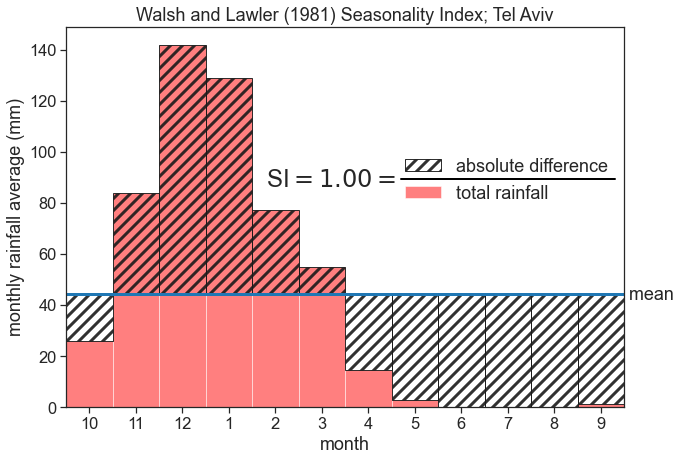

In [97]:
fig, ax = plt.subplots(figsize=(10,7))


plt.rcParams['hatch.linewidth'] = 3

# hydrological year starts in October, roll data by 9 months
months = df_london['month number']
months_to_roll = -9  # minus sign = roll data to the left
# london_rolled = np.roll(df_london['monthly rainfall (mm)'], months_to_roll)
telaviv_rolled = np.roll(df_telaviv['monthly rainfall (mm)'], months_to_roll)
months_rolled = np.roll(months, months_to_roll)
months_rolled_str = [str(x) for x in months_rolled]

# bar plots
# ax.bar(months, london_rolled,
#        alpha=0.5, color="blue",
#        label=f"London ({total_london:.0f} mm per year)")

xlim = [1, 13]
ax.plot(xlim, [total_telaviv/12]*2, color="tab:blue", linewidth=3)
ax.set_xlim(xlim)

shaded = telaviv_rolled - total_telaviv/12
ax.bar(months, shaded,
       alpha=0.9, color="None", width=1,
       hatch="//", edgecolor='k',
       align='edge', bottom=total_telaviv/12,
       label=f"absolute difference")

ax.bar(months, telaviv_rolled,
       alpha=0.5, color="red", width=1,
       align='edge',
       label=f"total rainfall", zorder=0)


ax.text(5.3, 86.5, r"SI$=1.00=$", fontsize=24)
ax.text(xlim[-1], total_telaviv/12, " mean", va="center")
ax.plot([8.2, 12.8], [89.5]*2, color="black", lw=2)
# # axes labels and figure title
ax.set_xlabel('month')
ax.set_ylabel('monthly rainfall average (mm)')
ax.set_title('Walsh and Lawler (1981) Seasonality Index; Tel Aviv')
ax.set_xticks(np.arange(1.5,12.6,1))
ax.set_xticklabels(months_rolled_str)
# ax.set_title('seasonality of two cities with similar yearly rainfall')

# # some ticks adjustments
# #
# ax.set_xticks(months)
# ax.set_xticklabels(months_rolled_str)
plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 0.7),
           fontsize=18)

# save figure
plt.savefig("hydrology_figures/si_walsh_telaviv.png")

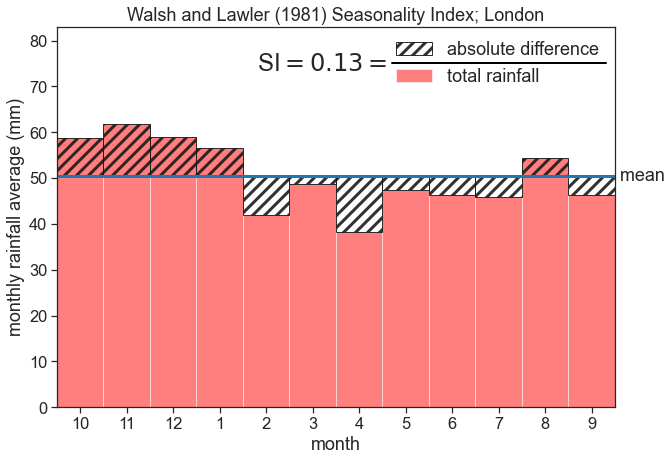

In [98]:
fig, ax = plt.subplots(figsize=(10,7))


plt.rcParams['hatch.linewidth'] = 3

# hydrological year starts in October, roll data by 9 months
months = df_london['month number']
months_to_roll = -9  # minus sign = roll data to the left
london_rolled = np.roll(df_london['monthly rainfall (mm)'], months_to_roll)
# telaviv_rolled = np.roll(df_telaviv['monthly rainfall (mm)'], months_to_roll)
months_rolled = np.roll(months, months_to_roll)
months_rolled_str = [str(x) for x in months_rolled]

xlim = [1, 13]
ax.plot(xlim, [total_london/12]*2, color="tab:blue", linewidth=3)
ax.set_xlim(xlim)

shaded = london_rolled - total_london/12
ax.bar(months, shaded,
       alpha=0.9, color="None", width=1,
       hatch="//", edgecolor='k',
       align='edge', bottom=total_london/12,
       label=f"absolute difference")

ax.bar(months, london_rolled,
       alpha=0.5, color="red", width=1,
       align='edge',
       label=f"total rainfall", zorder=0)


ax.text(5.3, 73.5, r"SI$=0.13=$", fontsize=24)
ax.text(xlim[-1], total_london/12, " mean", va="center")
ax.plot([8.2, 12.8], [75]*2, color="black", lw=2)
# # axes labels and figure title
ax.set_xlabel('month')
ax.set_ylabel('monthly rainfall average (mm)')
ax.set_title('Walsh and Lawler (1981) Seasonality Index; London')
ax.set_xticks(np.arange(1.5,12.6,1))
ax.set_xticklabels(months_rolled_str)
ax.set_ylim([0, 83])
# ax.set_title('seasonality of two cities with similar yearly rainfall')

# # some ticks adjustments
# #
# ax.set_xticks(months)
# ax.set_xticklabels(months_rolled_str)
plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 1.005),
           fontsize=18)

# save figure
plt.savefig("hydrology_figures/si_walsh_london.png")